In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# setting seed for model reproducibility
seed_value = 42
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)
import pandas as pd
import scipy.stats as stats

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import optimizers
from keras.optimizers import Adam
from time import time

# For hyperopt (parameter optimization)
# ! pip install hyperopt
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
from hyperopt import fmin, tpe, hp, Trials
from hyperopt.pyll.base import scope 

# plotting libraries
import matplotlib as mpl
import matplotlib.style
import seaborn as sns  # visualization
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
import joblib

In [3]:
!pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
df = pd.read_csv('/content/gdrive/My Drive/Thesis/Final_Real.csv', index_col=0)

In [5]:
# Splitting the dataset
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed_value)

In [7]:
# Rescale the features
scaler = StandardScaler() 
train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),
                                     index=X_train.index,
                                     columns=X_train.columns)
# The Scaler is fit on the training set and then applied to the test set
test_scaled = pd.DataFrame(scaler.transform(X_test.values),
                                    index=X_test.index,
                                    columns=X_test.columns)

train_scaled.shape, test_scaled.shape

((164563, 6), (70527, 6))

In [8]:
space = {'timestep' : scope.int(hp.quniform('timestep',10,50, 5)),
         'units' : scope.int(hp.quniform('units',10,30, 5)),
         'epochs' : scope.int(hp.quniform('epochs',10,50, 5)),
         'batch_size' : scope.int(hp.quniform('batch_size',10,50,5)),
         }

In [9]:
# Reshaping the time series and fitting into GRU

def f_nn(params):
  T = params['timestep']  # timesteps window
   
  # Transforming data into 3D shape
  X_train_1, y_train_1 = [], []
  for i in range(y_train.shape[0] - (T-1)):
      X_train_1.append(train_scaled.iloc[i:i+T].values)
      y_train_1.append(y_train.iloc[i + (T-1)])
  X_train_1, y_train_1 = np.array(X_train_1), np.array(y_train_1).reshape(-1,1)
  print(f'Train data dimensions: {X_train_1.shape}, {y_train_1.shape}')

  X_test_1, y_test_1 = [], []
  for i in range(y_test.shape[0] - (T-1)):
      X_test_1.append(test_scaled.iloc[i:i+T].values)
      y_test_1.append(y_test.iloc[i + (T-1)])
  X_test_1, y_test_1 = np.array(X_test_1), np.array(y_test_1).reshape(-1,1)  

  print(f'Test data dimensions: {X_test_1.shape}, {y_test_1.shape}')

  # defining the GRU model
  
  model = Sequential()
  model.add(GRU(units = params["units"], activation="relu", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
  model.add(GRU(units=params['units'], activation='relu'))
  model.add(Dense(9, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])   
  print(model.summary())

  # Define a learning rate decay method:
  lr_decay = ReduceLROnPlateau(monitor='loss', 
                              patience=1, verbose=1, 
                              factor=0.5, min_lr=1e-8)
  # Define Early Stopping:
  early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                            patience=30, verbose=1, mode='auto',
                            baseline=0, restore_best_weights=True)

  # Train the model. 
  start = time()
  result = model.fit(X_train_1, y_train_1,
                      epochs = params["epochs"],
                      batch_size = params["batch_size"],
                      validation_data=(X_test_1, y_test_1),
                      shuffle=True,verbose=1,
                      callbacks=[early_stop])
    
    
  # get the lowest validation loss of the training epochs
  validation_loss = np.nanmin(result.history['val_loss']) 
  print('Best validation loss of epoch:', validation_loss)
    
  return {'loss': validation_loss, 'status': STATUS_OK, 'model': model, 'params': params}

In [10]:
#trials = joblib.load('/content/gdrive/My Drive/Thesis/hyperopt_trials.pkl')
#_ = fmin(f_nn, 
#            space, 
#            algo=tpe.suggest,
#            max_evals=3,
#            trials=trials)

100%|██████████| 3/3 [00:00<?, ?trial/s, best loss=?]


In [19]:
trials = Trials()
best = fmin(f_nn, 
            space, 
            algo=tpe.suggest,
            max_evals=3,
            trials=trials)

joblib.dump(trials, '/content/gdrive/My Drive/Thesis/hyperopt_trials.pkl')

Streaming output truncated to the last 5000 lines.
6582/6582 [==============================] - 202s 31ms/step - loss: 0.0917 - accuracy: 0.9628 - val_loss: 0.0906 - val_accuracy: 0.9642

Epoch 15/15

6582/6582 [==============================] - 183s 28ms/step - loss: 0.0891 - accuracy: 0.9641 - val_loss: 0.0933 - val_accuracy: 0.9623

Best validation loss of epoch:
0.09059459716081619
100%|██████████| 3/3 [4:09:56<00:00, 4998.72s/trial, best loss: 0.04771726578474045]


['/content/gdrive/My Drive/Thesis/hyperopt_trials.pkl']

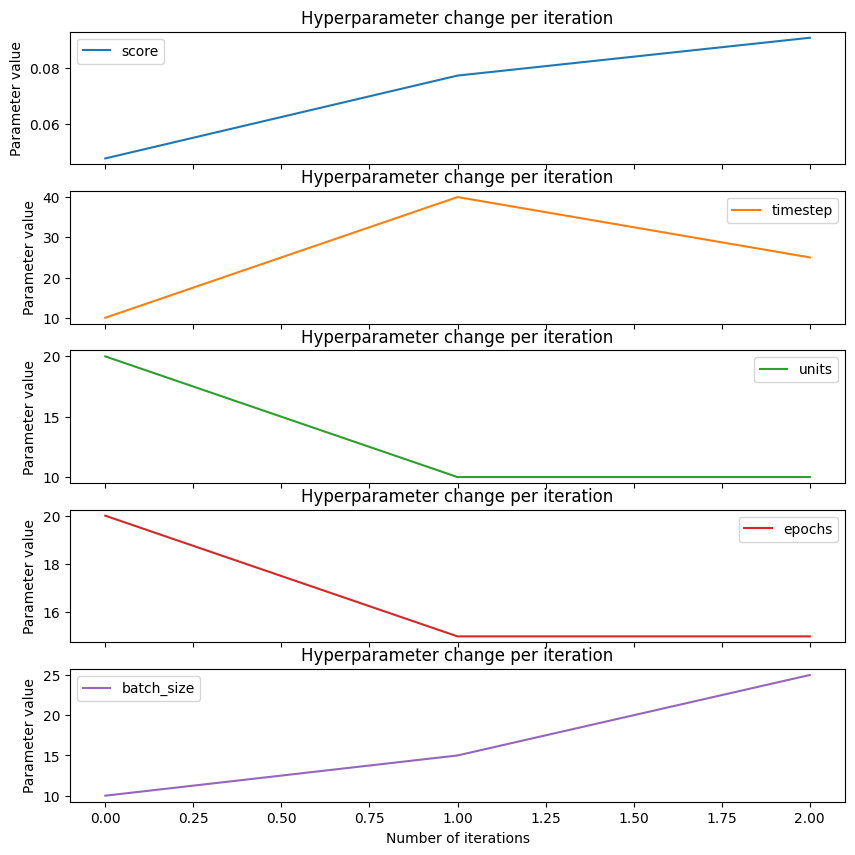

In [36]:
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['timestep'][0],
                      x['misc']['vals']['units'][0],
                      x['misc']['vals']['epochs'][0],
                      x['misc']['vals']['batch_size'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'timestep', 'units', 'epochs', 'batch_size'])
ax = tpe_results_df.plot(subplots=True,figsize=(10, 10))

for subplot in ax:
    subplot.set_xlabel("Number of iterations")
    subplot.set_ylabel("Parameter value")
    subplot.set_title("Hyperparameter change per iteration")

       
    subplot.legend()

In [41]:
def main_plot_history(trials, do_show=True, status_colors=None, title="Loss History"):
    # -- import here because file-level import is too early
    import matplotlib.pyplot as plt

    # self is an Experiment
    #if status_colors is None:
    #    status_colors = default_status_colors

    # XXX: show the un-finished or error trials
    Ys, colors = zip(
        *[
            (y, status_colors[s])
            for y, s in zip(trials.losses(), trials.statuses())
            if y is not None
        ]
    )
    plt.scatter(range(len(Ys)), Ys, c=colors)
    plt.xlabel("time")
    plt.ylabel("loss")

    best_err = trials.average_best_error()
    print("avg best error:", best_err)
    plt.axhline(best_err, c="g")

    plt.title(title)
    if do_show:
        plt.show()

In [21]:
best_params = trials.results[np.argmin([r['loss'] for r in 
    trials.results])]['params']

In [22]:
timestep=best_params['timestep']
units=best_params['units'] 
epochs = best_params["epochs"]
batch_size = best_params["batch_size"]

In [23]:
print('Best parameters are:', '\nWindow Size:',timestep, '\nNumber of Units:',units, '\nNumber of epochs:',epochs, '\nBatch sizes:',batch_size)

Best parameters are: 
Window Size: 10 
Number of Units: 20 
Number of epochs: 20 
Batch sizes: 10


In [24]:
# Transforming data into 3D shape
T = timestep
X_train_1, y_train_1 = [], []
for i in range(y_train.shape[0] - (T-1)):
    X_train_1.append(train_scaled.iloc[i:i+T].values)
    y_train_1.append(y_train.iloc[i + (T-1)])
X_train_1, y_train_1 = np.array(X_train_1), np.array(y_train_1).reshape(-1,1)
print(f'Train data dimensions: {X_train_1.shape}, {y_train_1.shape}')

X_test_1, y_test_1 = [], []
for i in range(y_test.shape[0] - (T-1)):
    X_test_1.append(test_scaled.iloc[i:i+T].values)
    y_test_1.append(y_test.iloc[i + (T-1)])
X_test_1, y_test_1 = np.array(X_test_1), np.array(y_test_1).reshape(-1,1)  

print(f'Test data dimensions: {X_test_1.shape}, {y_test_1.shape}')

Train data dimensions: (164554, 10, 6), (164554, 1)
Test data dimensions: (70518, 10, 6), (70518, 1)


In [25]:
model = Sequential()
model.add(GRU(units, activation="relu", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(GRU(units, activation='relu'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                                patience=1, verbose=1, 
                                factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                              patience=30, verbose=1, mode='auto',
                              baseline=0, restore_best_weights=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 10, 20)            1680      
                                                                 
 gru_9 (GRU)                 (None, 20)                2520      
                                                                 
 dense_4 (Dense)             (None, 9)                 189       
                                                                 
Total params: 4,389
Trainable params: 4,389
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
16456/16456 [==============================] - 212s 13ms/step - loss: 0.2083 - accuracy: 0.9346 - val_loss: 0.1291 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 2/20
16456/16456 [==============================] - 210s 13ms/step - loss: 0.1109 - accuracy: 0.9586 - val_loss: 0.1024 - val_accuracy: 0.9610 

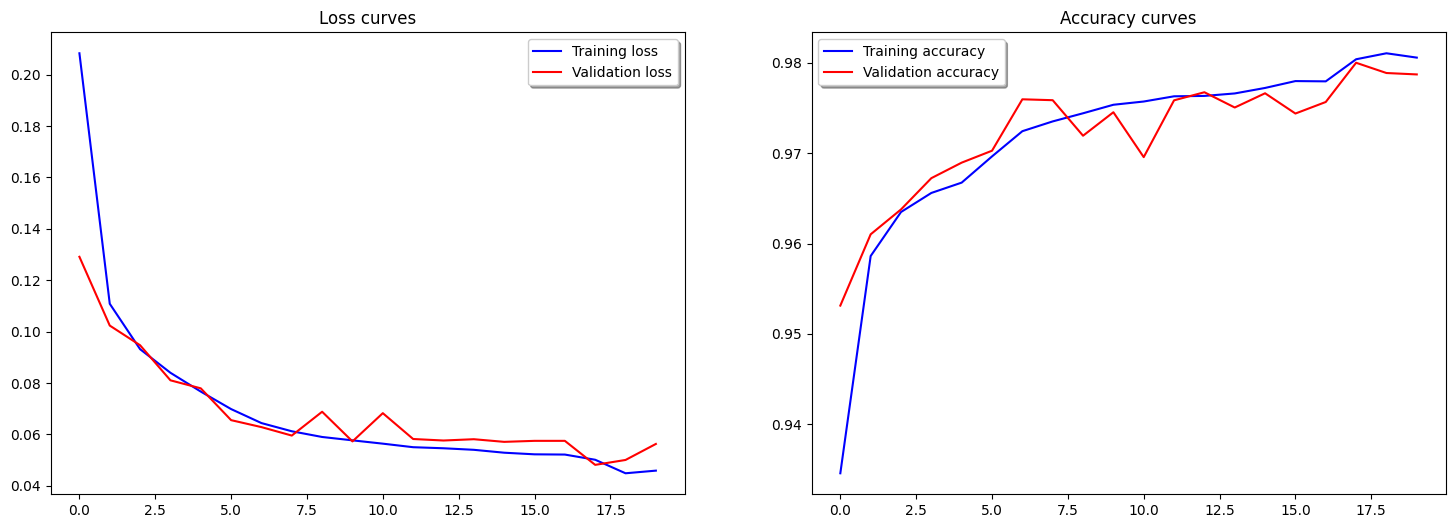

In [26]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [27]:
y_pred = np.argmax(model.predict(X_test_1), axis=-1)

2204/2204 [==============================] - 10s 4ms/step


<Axes: >

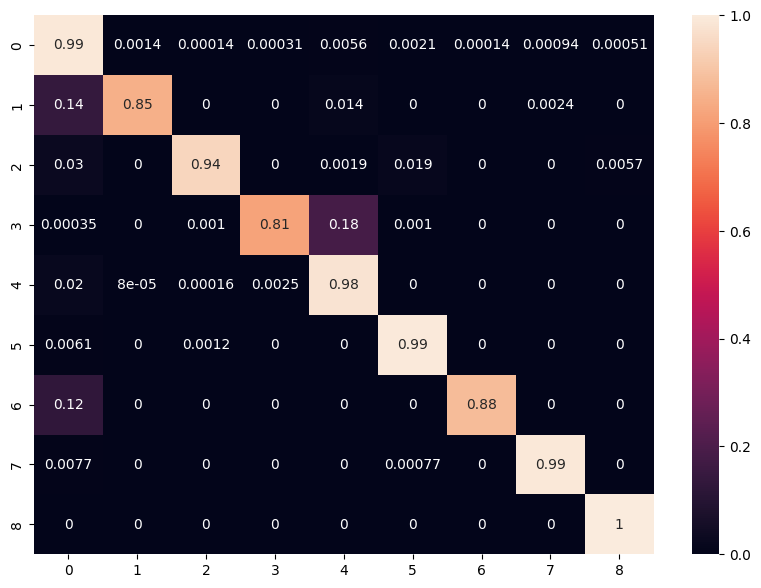

In [28]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

In [29]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred))
    
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.9787004736379364
Confusion Matrix: 
 [[50260    69     7    16   284   107     7    48    26]
 [   58   355     0     0     6     0     0     1     0]
 [   16     0   500     0     1    10     0     0     3]
 [    1     0     3  2329   522     3     0     0     0]
 [  245     1     2    31 12163     0     0     0     0]
 [   10     0     2     0     0  1632     0     0     0]
 [   12     0     0     0     0     0    84     0     0]
 [   10     0     0     0     0     1     0  1282     0]
 [    0     0     0     0     0     0     0     0   411]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     50824
           1       0.84      0.85      0.84       420
           2       0.97      0.94      0.96       530
           3       0.98      0.81      0.89      2858
           4       0.94      0.98      0.96     12442
           5       0.93      0.99      0.96      1644
           6